In [20]:

import numpy as np
from scipy.misc.pilutil import imresize
import cv2 #version 3.2.0
from skimage.feature import hog
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import time
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

In [21]:

DIGIT_WIDTH = 10 
DIGIT_HEIGHT = 20
IMG_HEIGHT = 28
IMG_WIDTH = 28
CLASS_N = 10 # 0-9


In [22]:
#This method splits the input training image into small cells (of a single digit) and uses these cells as training data.
#The default training image (MNIST) is a 1000x1000 size image and each digit is of size 10x20. so we divide 1000/10 horizontally and 1000/20 vertically.
def split2d(img, cell_size, flatten=True):
    h, w = img.shape[:2]
    sx, sy = cell_size
    cells = [np.hsplit(row, w//sx) for row in np.vsplit(img, h//sy)]
    cells = np.array(cells)
    if flatten:
        cells = cells.reshape(-1, sy, sx)
    return cells

In [23]:
def load_digits(fn):
    print('loading "%s for training" ...' % fn)
    digits_img = cv2.imread(fn, 0)
    digits = split2d(digits_img, (DIGIT_WIDTH, DIGIT_HEIGHT))
    resized_digits = []
    for digit in digits:
        resized_digits.append(imresize(digit,(IMG_WIDTH, IMG_HEIGHT)))
    labels = np.repeat(np.arange(CLASS_N), len(digits)/CLASS_N)
    return np.array(resized_digits), labels

def pixels_to_hog_20(img_array):
    hog_featuresData = []
    for img in img_array:
        fd = hog(img, 
                 orientations=10, 
                 pixels_per_cell=(5,5),
                 cells_per_block=(1,1), 
                 visualise=False)
        hog_featuresData.append(fd)
    hog_features = np.array(hog_featuresData, 'float64')
    return np.float32(hog_features)

In [24]:
#define a custom model in a similar class wrapper with train and predict methods
class KNN_MODEL():
    def __init__(self, k = 3):
        self.k = k
        self.model = cv2.ml.KNearest_create()

    def train(self, samples, responses):
        self.model.train(samples, cv2.ml.ROW_SAMPLE, responses)

    def predict(self, samples):
        retval, results, neigh_resp, dists = self.model.findNearest(samples, self.k)
        return results.ravel()

class SVM_MODEL():
    def __init__(self, num_feats, C = 1, gamma = 0.1):
        self.model = cv2.ml.SVM_create()
        self.model.setType(cv2.ml.SVM_C_SVC)
        self.model.setKernel(cv2.ml.SVM_RBF) #SVM_LINEAR, SVM_RBF
        self.model.setC(C)
        self.model.setGamma(gamma)
        self.features = num_feats

    def train(self, samples, responses):
        self.model.train(samples, cv2.ml.ROW_SAMPLE, responses)

    def predict(self, samples):
        results = self.model.predict(samples.reshape(-1,self.features))
        return results[1].ravel()


In [25]:
def get_digits(contours, hierarchy):
    hierarchy = hierarchy[0]
    bounding_rectangles = [cv2.boundingRect(ctr) for ctr in contours]   
    final_bounding_rectangles = []
    #find the most common heirarchy level - that is where our digits's bounding boxes are
    u, indices = np.unique(hierarchy[:,-1], return_inverse=True)
    most_common_heirarchy = u[np.argmax(np.bincount(indices))]
    
    for r,hr in zip(bounding_rectangles, hierarchy):
        x,y,w,h = r
        #this could vary depending on the image you are trying to predict
        #we are trying to extract ONLY the rectangles with images in it (this is a very simple way to do it)
        #we use heirarchy to extract only the boxes that are in the same global level - to avoid digits inside other digits
        #ex: there could be a bounding box inside every 6,9,8 because of the loops in the number's appearence - we don't want that.
        #read more about it here: https://docs.opencv.org/trunk/d9/d8b/tutorial_py_contours_hierarchy.html
        if ((w*h)>250) and (10 <= w <= 200) and (10 <= h <= 200) and hr[3] == most_common_heirarchy: 
            final_bounding_rectangles.append(r)    

    return final_bounding_rectangles


def proc_user_img(img_file, model):
    print('loading "%s for digit recognition" ...' % img_file)
    im = cv2.imread(img_file)    
    blank_image = np.zeros((im.shape[0],im.shape[1],3), np.uint8)
    blank_image.fill(255)

    imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    plt.imshow(imgray)
    kernel = np.ones((5,5),np.uint8)
    
    ret,thresh = cv2.threshold(imgray,127,255,0)   
    thresh = cv2.erode(thresh,kernel,iterations = 1)
    thresh = cv2.dilate(thresh,kernel,iterations = 1)
    thresh = cv2.erode(thresh,kernel,iterations = 1)
    
    _,contours,hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    digits_rectangles = get_digits(contours,hierarchy)  #rectangles of bounding the digits in user image
    
    for rect in digits_rectangles:
        x,y,w,h = rect
        cv2.rectangle(im,(x,y),(x+w,y+h),(0,255,0),2)
        im_digit = imgray[y:y+h,x:x+w]
        im_digit = (255-im_digit)
        im_digit = imresize(im_digit,(IMG_WIDTH ,IMG_HEIGHT))

        hog_img_data = pixels_to_hog_20([im_digit])  
        pred = model.predict(hog_img_data)
        cv2.putText(im, str(int(pred[0])), (x,y),cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 3)
        cv2.putText(blank_image, str(int(pred[0])), (x,y),cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 5)

    plt.imshow(im)
    cv2.imwrite("original_overlay.png",im) 
    cv2.imwrite("final_digits.png",blank_image) 
    cv2.destroyAllWindows()           


In [26]:
def get_contour_precedence(contour, cols):
    return contour[1] * cols + contour[0]  #row-wise ordering


#this function processes a custom training image
#see example : custom_train.digits.jpg
#if you want to use your own, it should be in a similar format
def load_digits_custom(img_file):
    train_data = []
    train_target = []
    start_class = 1
    im = cv2.imread(img_file)
    imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    plt.imshow(imgray)
    kernel = np.ones((5,5),np.uint8)
    
    ret,thresh = cv2.threshold(imgray,127,255,0)   
    thresh = cv2.erode(thresh,kernel,iterations = 1)
    thresh = cv2.dilate(thresh,kernel,iterations = 1)
    thresh = cv2.erode(thresh,kernel,iterations = 1)
    
    _,contours,hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    digits_rectangles = get_digits(contours,hierarchy)  #rectangles of bounding the digits in user image
    
    #sort rectangles accoring to x,y pos so that we can label them
    digits_rectangles.sort(key=lambda x:get_contour_precedence(x, im.shape[1]))
    
    for index,rect in enumerate(digits_rectangles):
        x,y,w,h = rect
        cv2.rectangle(im,(x,y),(x+w,y+h),(0,255,0),2)
        im_digit = imgray[y:y+h,x:x+w]
        im_digit = (255-im_digit)
        
        im_digit = imresize(im_digit,(IMG_WIDTH, IMG_HEIGHT))
        train_data.append(im_digit)
        train_target.append(start_class%10)

        if index>0 and (index+1) % 10 == 0:
            start_class += 1
    cv2.imwrite("training_box_overlay.png",im)
    
    return np.array(train_data), np.array(train_target)

C:\Users\GOPAL GUPTA\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


train data shape (100, 28, 28)
test data shape (100,)


C:\Users\GOPAL GUPTA\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


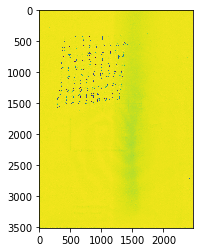

In [27]:
TRAIN_MNIST_IMG = 'digits.png' 
TRAIN_USER_IMG = 'custom_train_digits.jpg'
TEST_USER_IMG = 'test_image.png'

#digits, labels = load_digits(TRAIN_MNIST_IMG) #original MNIST data (not good detection)
digits, labels = load_digits_custom(TRAIN_USER_IMG) #my handwritten dataset (better than MNIST on my handwritten digits)

print('train data shape',digits.shape)
print('test data shape',labels.shape)

digits, labels = shuffle(digits, labels, random_state=256)
train_digits_data = pixels_to_hog_20(digits)
X_train, X_test, y_train, y_test = train_test_split(train_digits_data, labels, test_size=0.33, random_state=42)

Accuracy:  0.7878787878787878
loading "test_image.png for digit recognition" ...


C:\Users\GOPAL GUPTA\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\Users\GOPAL GUPTA\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


total time used is  0.49966001510620117 secs.


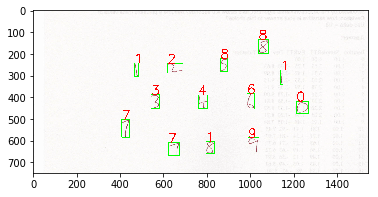

In [19]:
start = time.time()
model = KNN_MODEL(k = 3)
model.train(X_train, y_train)
preds = model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, preds))

model = KNN_MODEL(k = 4)
model.train(train_digits_data, labels)
proc_user_img(TEST_USER_IMG, model)
end = time.time()

print('total time used is ', str(end - start), 'secs.')

Accuracy:  0.696969696969697
loading "test_image.png for digit recognition" ...


C:\Users\GOPAL GUPTA\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\Users\GOPAL GUPTA\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


total time used is  0.5941357612609863 secs.


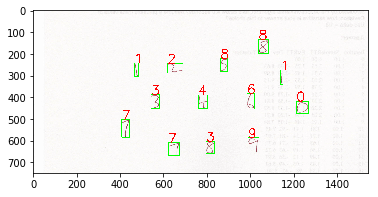

In [10]:
start = time.time()
model = SVM_MODEL(num_feats = train_digits_data.shape[1])
model.train(X_train, y_train)
preds = model.predict(X_test)
end = time.time()
print('Accuracy: ',accuracy_score(y_test, preds))

model = SVM_MODEL(num_feats = train_digits_data.shape[1])
model.train(train_digits_data, labels)
proc_user_img(TEST_USER_IMG, model)
end = time.time()

print('total time used is ', str(end - start), 'secs.')